### ***Contributed by:-***

Divyanshi Bhojak(202IT007)

Tarushi Jat (202IT029)

### ***Description:*** 

Classification with SVHN dataset using Cyclical Learning Rate VGG16 Architecture.
****

### **Libraries Used**

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-i_k2dd6z
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-i_k2dd6z
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=e6526161476b1df2ebf48bb4f6d2bf67e5e8a498a04d0062df75f692b1f501cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-s71d7m4w/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd
from keras_contrib.callbacks import CyclicLR
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
import seaborn as sns

### **Defining AdamW Optimizer**

In [ ]:
class Optimizer:
    def __init__(self, learning_rate=None, name=None):
        self.learning_rate = learning_rate
        self.name = name

    def config(self, layers):
        # sets up empty cache dictionaries 
        pass

    def optimize(self, idx, layers: list, grads: dict, *args):
        
        pass 

In [ ]:
class AdamW(Adam):  
    
    def __init__(self, learning_rate, gamma_init=1e-5, decay_rate=0.8, **kwargs):
        super().__init__(**kwargs)
        self.learning_rate = learning_rate
        self.gamma_init = gamma_init
        self.decay_rate = decay_rate
    
    def optimize(self, idx, layers, grads, epoch_num, steps):
        gamma = self.gamma_init * self.decay_rate ** int(epoch_num / 5) 
        dW = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        self.m[f'W{idx}'] = self.beta1 * self.m[f'W{idx}'] + (1 - self.beta1) * dW
        self.v[f'W{idx}'] = self.beta2 * self.v[f'W{idx}'] + (1 - self.beta2) * dW ** 2 

        self.m[f'b{idx}'] = self.beta1 * self.m[f'b{idx}'] + (1 - self.beta1) * db
        self.v[f'b{idx}'] = self.beta2 * self.v[f'b{idx}'] + (1 - self.beta2) * db ** 2 

        mt_w  = self.m[f'W{idx}'] / (1 - self.beta1 ** steps)
        vt_w = self.v[f'W{idx}'] / (1 - self.beta2 ** steps)

        mt_b  = self.m[f'b{idx}'] / (1 - self.beta1 ** steps)
        vt_b = self.v[f'b{idx}'] / (1 - self.beta2 ** steps)

        w_update = - self.learning_rate * mt_w / ((np.sqrt(vt_w) + self.epsilon) + gamma * layers[idx].W) 
        b_update = - self.learning_rate * mt_b / ((np.sqrt(vt_b) + self.epsilon) + gamma * layers[idx].b)

        layers[idx].W += w_update
        layers[idx].b += b_update


### **SVHN Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Method for Loading, Pre-processing & Splitting Dataset**

In [ ]:
def svhn_data_split():
    x_train = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/train_32x32.mat")['X'] 
    y_train = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/train_32x32.mat")['y']
    x_test = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/test_32x32.mat")['X']
    y_test = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/test_32x32.mat")['y']
    
    img_rows, img_cols = 32, 32
    num_classes = 10 

    X_train = []
    for i in range(x_train.shape[3]):
        X_train.append(x_train[:,:,:,i])
    X_train = np.asarray(X_train)
    
    X_test = []
    for i in range(x_test.shape[3]):
        X_test.append(x_test[:,:,:,i])
    X_test = np.asarray(X_test)

    y_test1 = y_test.reshape((26032, ))
    y_test1 = [y-1 for y in y_test1]
    y_train1 = y_train.reshape((73257, ))
    y_train1 = [y-1 for y in y_train1]    
    
    input_shape = (img_rows, img_cols, 3)
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    X_train /= 255
    X_test /= 255
    print('x_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    
    y_train2 = keras.utils.to_categorical(y_train1, num_classes)
    y_test2 = keras.utils.to_categorical(y_test1, num_classes)
    
    y_train2 = y_train2.astype('int32')
    y_test2 = y_test2.astype('int32')

    
    print("after process: X train shape: {}, X test shape: {}, y train shape: {}, y test shape: {}".format(x_train.shape, x_test.shape, y_train2.shape, y_test2.shape))
    return  input_shape, X_train, X_test, y_train2, y_test2

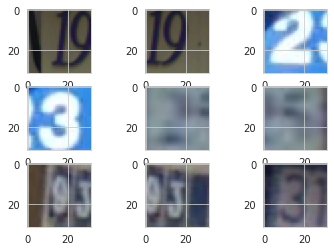

In [ ]:
#Images before augmentation
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
#setting up image augmentation
def augment():
  datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
  datagen.fit(x_train)

### **Performance Metrics Used**
1. Computation & cost time
2. Accuracy
3. Confusion Matrix
4. Classification Report

In [ ]:
def perf_metrics_acc(model):
  score = model.evaluate(x_test,y_test,verbose=0)
  print("Test Loss : {:.4f}".format(score[0]))
  print("Test Accuracy : {:.2f}".format(score[1]*100),"%")

In [ ]:
def per_metrics_2(y_test, pred):
  print("*******************Classification Report*******************\n")
  print(classification_report(y_test, pred))
  print("*******************Confusion Matrix*******************\n")
  print(confusion_matrix(y_test, pred))

### **Plotting Graph Methods**

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def display_cm(y_test, model_pred):
  CM = confusion_matrix(y_test, model_pred)
  f, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()

### **Model Architecture**

In [ ]:
def self_model_arch():

    reg=None
    num_filters=32
    ac='relu'
    adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt=adm
    drop_dense=0.5
    drop_conv=0
    batch_size = 32 
    num_classes = 10

    model = Sequential()

    model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
    model.add(Dropout(drop_conv))

    model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
    model.add(Dropout(drop_conv))

    model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
    model.add(Dropout(drop_conv))

    model.add(Flatten())
    model.add(Dense(512, activation=ac,kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    return model

In [ ]:
model = self_model_arch()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

### **Cyclical Learning Rate**

In [ ]:
clr = CyclicLR(
    base_lr=0.001,
    max_lr=0.005,
    step_size=2000,
    mode='triangular')

### **Optimizer  Adam**

In [ ]:
input_shape, x_train, x_test, y_train, y_test = svhn_data_split()

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
after process: X train shape: (32, 32, 3, 73257), X test shape: (32, 32, 3, 26032), y train shape: (73257, 10), y test shape: (26032, 10)


In [ ]:
datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(x_train)

In [ ]:
model_1 = self_model_arch()
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### **Model Training: with image augmentation**

In [ ]:
m_1 = model_1.fit(datagen.flow(x_train, y_train, batch_size=128),steps_per_epoch = len(x_train) / 128, epochs=50, validation_data=(x_test, y_test), callbacks=[clr], shuffle=True)

Epoch 1/50
572/572 [==============================] - 72s 68ms/step - loss: 1.8921 - accuracy: 0.4408 - val_loss: 0.5279 - val_accuracy: 0.8340
Epoch 2/50
572/572 [==============================] - 39s 68ms/step - loss: 0.6017 - accuracy: 0.8084 - val_loss: 0.5704 - val_accuracy: 0.8302
Epoch 3/50
572/572 [==============================] - 39s 68ms/step - loss: 0.4974 - accuracy: 0.8437 - val_loss: 0.4297 - val_accuracy: 0.8712
Epoch 4/50
572/572 [==============================] - 39s 68ms/step - loss: 0.4360 - accuracy: 0.8643 - val_loss: 0.4198 - val_accuracy: 0.8690
Epoch 5/50
572/572 [==============================] - 39s 68ms/step - loss: 0.3669 - accuracy: 0.8893 - val_loss: 0.2616 - val_accuracy: 0.9218
Epoch 6/50
572/572 [==============================] - 39s 68ms/step - loss: 0.3295 - accuracy: 0.9025 - val_loss: 0.2210 - val_accuracy: 0.9383
Epoch 7/50
572/572 [==============================] - 39s 68ms/step - loss: 0.2829 - accuracy: 0.9153 - val_loss: 0.1933 - val_accuracy:

### **Performance Metrics Analysis for Model with Adam Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model_1)

Test Loss : 0.1810
Test Accuracy : 95.24 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model_1.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5099
           1       0.97      0.96      0.97      4149
           2       0.92      0.92      0.92      2882
           3       0.96      0.96      0.96      2523
           4       0.95      0.94      0.95      2384
           5       0.93      0.95      0.94      1977
           6       0.97      0.93      0.95      2019
           7       0.94      0.95      0.95      1660
           8       0.92      0.95      0.93      1595
           9       0.97      0.96      0.96      1744

    accuracy                           0.95     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.95      0.95      0.95     26032

*******************Confusion Matrix*******************

[[4954   15   26   33    7   10   30    6    4   14]
 [  17 3977   51   27   31   12   12    6   10    6]
 [  22   23 2659  

**3. Visualizing accuracy for every epoch**

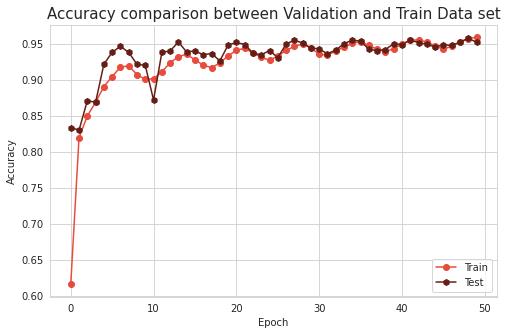

In [ ]:
acc_plot(m_1)

**4. Visualizing loss in every epoch**

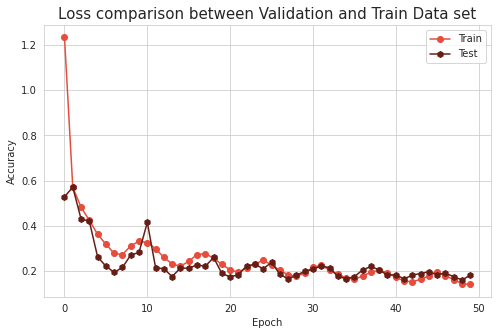

In [ ]:
loss_plot(m_1)

**5. Visualizing Confusion Matrix**

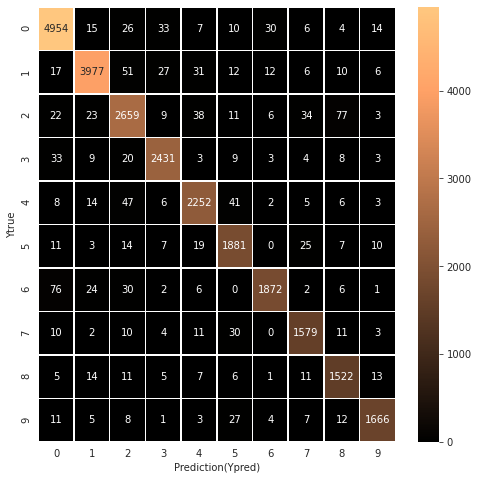

In [ ]:
display_cm(y_test, pred)

### **Optimizer  AdamW**

In [ ]:
input_shape, x_train, x_test, y_train, y_test = svhn_data_split()
augment()

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
after process: X train shape: (32, 32, 3, 73257), X test shape: (32, 32, 3, 26032), y train shape: (73257, 10), y test shape: (26032, 10)


In [ ]:
model_2 = self_model_arch()

model_2.compile(loss='categorical_crossentropy', optimizer= AdamW(0.005), metrics=['accuracy'])

### **Model Training: with image augmentation**

In [ ]:
m_2 = model_2.fit(datagen.flow(x_train, y_train, batch_size=128), steps_per_epoch = len(x_train) / 128, epochs=50, validation_data=(x_test, y_test), callbacks=[clr], shuffle=True)

Epoch 1/50
572/572 [==============================] - 40s 69ms/step - loss: 1.8855 - accuracy: 0.4343 - val_loss: 0.5258 - val_accuracy: 0.8320
Epoch 2/50
572/572 [==============================] - 39s 67ms/step - loss: 0.5757 - accuracy: 0.8184 - val_loss: 0.5369 - val_accuracy: 0.8451
Epoch 3/50
572/572 [==============================] - 39s 68ms/step - loss: 0.4846 - accuracy: 0.8503 - val_loss: 0.3492 - val_accuracy: 0.8992
Epoch 4/50
572/572 [==============================] - 39s 68ms/step - loss: 0.3877 - accuracy: 0.8817 - val_loss: 0.2680 - val_accuracy: 0.9199
Epoch 5/50
572/572 [==============================] - 39s 68ms/step - loss: 0.3349 - accuracy: 0.8993 - val_loss: 0.2347 - val_accuracy: 0.9325
Epoch 6/50
572/572 [==============================] - 39s 68ms/step - loss: 0.2869 - accuracy: 0.9143 - val_loss: 0.2156 - val_accuracy: 0.9391
Epoch 7/50
572/572 [==============================] - 39s 67ms/step - loss: 0.2728 - accuracy: 0.9185 - val_loss: 0.2698 - val_accuracy:

### **Performance Metrics Analysis for Model with AdamW Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model_2)

Test Loss : 0.1847
Test Accuracy : 95.01 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model_2.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5099
           1       0.96      0.96      0.96      4149
           2       0.95      0.90      0.93      2882
           3       0.94      0.97      0.96      2523
           4       0.96      0.95      0.95      2384
           5       0.90      0.96      0.93      1977
           6       0.95      0.93      0.94      2019
           7       0.96      0.94      0.95      1660
           8       0.92      0.95      0.93      1595
           9       0.96      0.95      0.96      1744

    accuracy                           0.95     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.95      0.95      0.95     26032

*******************Confusion Matrix*******************

[[4914   23   12   55    8   14   54    3    4   12]
 [  24 3996   29   29   20   19   12    2   13    5]
 [  33   43 2602  

**3. Visualizing accuracy for every epoch**

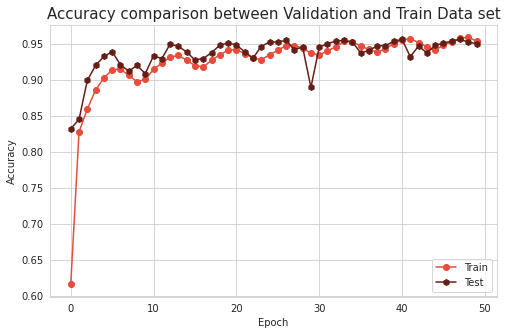

In [ ]:
acc_plot(m_2)

**4. Visualizing loss in every epoch**

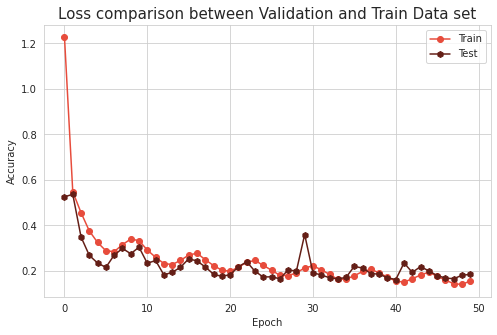

In [ ]:
loss_plot(m_2)

**5. Visualizing Confusion Matrix**

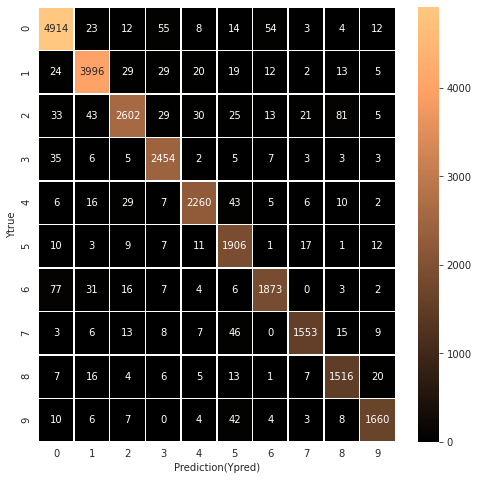

In [ ]:
display_cm(y_test, pred)

### **Optimizer  SGD with Momemtum**

In [ ]:
input_shape, x_train, x_test, y_train, y_test = svhn_data_split()
augment()

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
after process: X train shape: (32, 32, 3, 73257), X test shape: (32, 32, 3, 26032), y train shape: (73257, 10), y test shape: (26032, 10)


In [ ]:
model_3 = self_model_arch()
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False)
model_3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### **Model Training: with image augmentation**

In [ ]:
m_3 = model_3.fit(datagen.flow(x_train, y_train, batch_size=128),steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_test, y_test), callbacks=[clr], shuffle=True)

Epoch 1/100
572/572 [==============================] - 40s 68ms/step - loss: 1.5375 - accuracy: 0.5137 - val_loss: 0.7240 - val_accuracy: 0.7769
Epoch 2/100
572/572 [==============================] - 39s 68ms/step - loss: 0.8516 - accuracy: 0.7226 - val_loss: 0.5305 - val_accuracy: 0.8370
Epoch 3/100
572/572 [==============================] - 39s 68ms/step - loss: 0.7169 - accuracy: 0.7696 - val_loss: 0.4620 - val_accuracy: 0.8582
Epoch 4/100
572/572 [==============================] - 39s 68ms/step - loss: 0.6444 - accuracy: 0.7934 - val_loss: 0.5138 - val_accuracy: 0.8422
Epoch 5/100
572/572 [==============================] - 39s 69ms/step - loss: 0.5796 - accuracy: 0.8143 - val_loss: 0.3621 - val_accuracy: 0.8915
Epoch 6/100
572/572 [==============================] - 39s 69ms/step - loss: 0.5254 - accuracy: 0.8348 - val_loss: 0.3978 - val_accuracy: 0.8792
Epoch 7/100
572/572 [==============================] - 40s 70ms/step - loss: 0.4627 - accuracy: 0.8550 - val_loss: 0.2953 - val_ac

### **Performance Metrics Analysis for Model with SGD-M Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model_3)

Test Loss : 0.1713
Test Accuracy : 95.41 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model_3.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5099
           1       0.97      0.96      0.97      4149
           2       0.94      0.93      0.94      2882
           3       0.96      0.98      0.97      2523
           4       0.95      0.95      0.95      2384
           5       0.94      0.94      0.94      1977
           6       0.96      0.94      0.95      2019
           7       0.96      0.94      0.95      1660
           8       0.92      0.95      0.94      1595
           9       0.95      0.96      0.96      1744

    accuracy                           0.95     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.95      0.95      0.95     26032

*******************Confusion Matrix*******************

[[4929   25   18   45    6    5   39    8    4   20]
 [  29 3991   34   14   30   11   19    2   12    7]
 [  27   25 2687  

**3. Visualizing accuracy for every epoch**

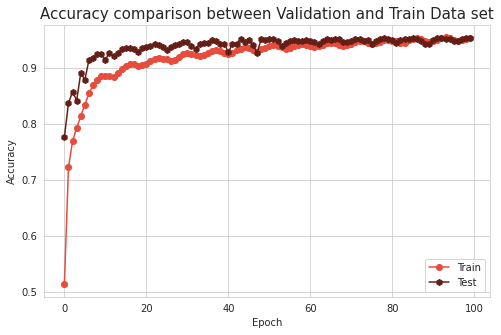

In [ ]:
acc_plot(m_3)

**4. Visualizing loss in every epoch**

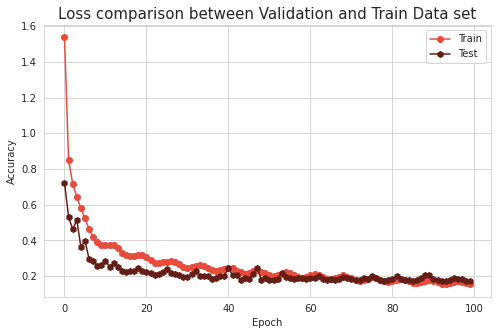

In [ ]:
loss_plot(m_3)

**5. Visualizing Confusion Matrix**

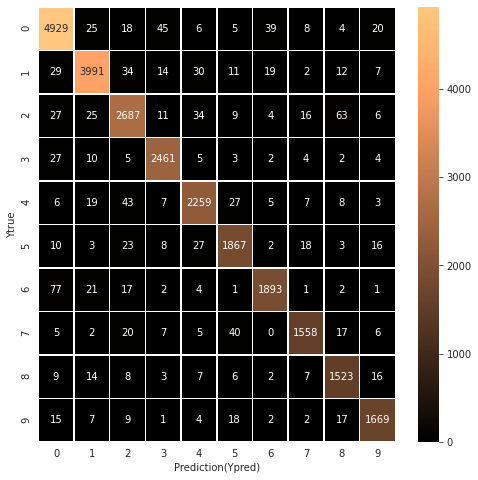

In [ ]:
display_cm(y_test, pred)

**END.**